In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import utilities

In [2]:
def plot_series(series, time=None, line='-', start=0, end=None, label=None,
                vlinex=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if time is None:
        time = range(len(series))
    ax.plot(time[start:end], series[start:end], line, label=label)
    if vlinex is not None:
        ax.axvline(vlinex, c='r')
    utilities.set_ax(ax, xlabel='Time', legend=label is not None, grid=True)
    
def trend(time, slope=0):
    return slope * time

pattern = lambda t: np.where(t < 0.4, np.cos(2*np.pi*t), np.exp(-3*t))

def pattern2series(pattern, time, period, amp=1, phase=0):
    return amp*pattern((time/period + phase) % 1)

def noise(time, noise_std=1, rng=np.random.RandomState(0)):
    return rng.randn(len(time)) * noise_std

def autocor(time, lags, coefs, noise_std=1, ini=0, rng=np.random.RandomState(0)):
    maxlag = max(lags)
    s = rng.randn(maxlag + len(time)) * noise_std
    s[:maxlag] += ini
    for i in range(maxlag, maxlag + len(time)):
        s[i] += sum(c*s[i-lag]for lag, c in zip(lags, coefs))
    return s[maxlag:]

def autocor2(time, coef, noise_std=1, rng=np.random.RandomState(0)):
    s = rng.randn(len(time)) * noise_std
    for i in range(1, len(time)):
        s[i] += coef * s[i-1]
    return s

def impulse(time, num, amp=1, rng=np.random.RandomState(0)):
    ind = rng.choice(np.arange(len(time)), num, replace=False)
    s = np.zeros_like(time, dtype=np.float64)
    s[ind] += rng.rand(num) * amp
    return s

def autocor3(series, lagcoef):
    s = series.copy()
    for i, _ in enumerate(s):
        s[i] += sum(coef * s[i-lag] for lag, coef in lagcoef.items() if i >= lag)
    return s

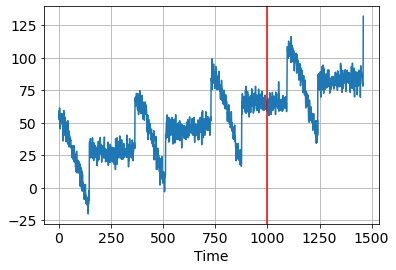

In [3]:
time = np.arange(4*365 + 1.)

baseline = 10
amp = 40
slope = 0.05
noise_std = 5

series = (baseline + trend(time, slope=slope)
          + pattern2series(pattern, time, period=365, amp=amp)
          + noise(time, noise_std=noise_std))

train_size = 1000

train_s, val_s = series[:train_size], series[train_size:]
train_t, val_t = time[:train_size], time[train_size:]

plot_series(series, time, vlinex=time[train_size])

In [4]:
def series2data(series, window, batch, buffer=None):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(size=window+1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window + 1))
    data = data.map(lambda ts: (ts[:-1], ts[-1]))
    data = data.shuffle(buffer_size=len(series) if buffer is None else buffer)
    data = data.batch(batch).prefetch(1)
    return data

In [5]:
window = 20
batch = 32

train_data = series2data(train_s, window=window, batch=batch)
val_data = series2data(val_s, window=window, batch=batch)

for d in train_data.take(1):
    print(type(d), d[0].shape, d[1].shape)

<class 'tuple'> (32, 20) (32,)


In [6]:
def fit_nn(model, epochs=20, lr=8e-6, mom=0.9, vb=0):
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=30, restore_best_weights=True
    )
    callbacks = [early_stop]
    
    if lr <= 0:
        ep2lr = lambda ep: 1e-8 * 10**(ep/20)
        callbacks.append(keras.callbacks.LearningRateScheduler(ep2lr))
    
    model.compile(
        loss=keras.losses.Huber(),
        optimizer=keras.optimizers.SGD(learning_rate=lr if lr > 0 else ep2lr(0),
                                       momentum=mom),
        metrics=['mae'],
    )
    
    history = model.fit(
        train_data, epochs=epochs, validation_data=val_data,
        callbacks=callbacks, verbose=vb
    )
    
    if lr > 0:
        utilities.plot_train_val_metrics(history, ['loss', 'mae'], start=5)
    else:
        fig, axs = plt.subplots(1, 2, figsize=[14, 4])
        lrs = ep2lr(np.array(history.epoch))
        for ax in axs:
            ax.semilogx(lrs, history.history['loss'], label='train')
            ax.semilogx(lrs, history.history['val_loss'], label='val')
            utilities.set_ax(ax, 'Learning rate', title='loss', legend=True, grid=True)
        min_loss = min(history.history['loss'])
        axs[1].set_ylim([min_loss, 3*min_loss])
        axs[1].set_xlim([lrs[len(lrs)//2], lrs[-1]])
    
    return model

In [7]:
def plot_pred(model, name='model', combined=False):
    full_data = series2data(series, window=window, batch=128, buffer=1)
    data_x = full_data.map(lambda x, y: x)
    pred = model.predict(data_x).squeeze()
    
    if combined:
        fig, ax = plt.subplots()
        ax.axvline(time[train_size], c='r')
        plot_series(np.c_[series[window:], pred], time[window:], ax=ax,
                    label=['truth', name])

    t_trn, t_val = time[window:train_size], time[train_size:]
    s_trn, s_val = series[window:train_size], series[train_size:]
    pred_trn, pred_val = pred[:train_size-window], pred[train_size-window:]

    rmse_trn = np.sqrt(keras.metrics.mean_squared_error(s_trn, pred_trn))
    mae_trn = keras.metrics.mean_absolute_error(s_trn, pred_trn)

    rmse_val = np.sqrt(keras.metrics.mean_squared_error(s_val, pred_val))
    mae_val = keras.metrics.mean_absolute_error(s_val, pred_val)

    fig, axs = plt.subplots(1, 2, figsize=[14, 4])
    plot_series(np.c_[s_trn, pred_trn], t_trn, ax=axs[0],
                label=('truth', f'{name} rmse={rmse_trn:.3g}, mae={mae_trn:.3g}'))
    plot_series(np.c_[s_val, pred_val], t_val, ax=axs[1],
                label=('truth', f'{name} rmse={rmse_val:.3g}, mae={mae_val:.3g}'))

In [8]:
def build_nn(dense_d=0):
    if dense_d == 0:
        layers = [keras.layers.Dense(1, input_shape=[window])]
    elif isinstance(dense_d, int):
        layers = [
            keras.layers.Dense(dense_d, input_shape=[window], activation='relu'),
            keras.layers.Dense(1),
        ]
    else:
        layers = (
            [keras.layers.Dense(dense_d[0], input_shape=[window], activation='relu')]
            + [keras.layers.Dense(d, activation='relu') for d in dense_d[1:]]
            + [keras.layers.Dense(1)]
        )   
        
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 27.5 s
Wall time: 16.6 s


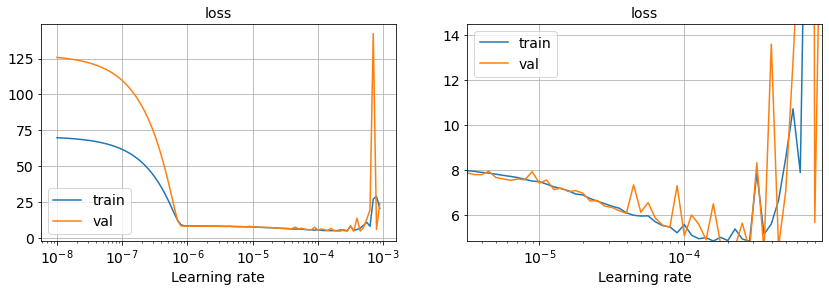

In [169]:
%%time
model = fit_nn(build_nn(), epochs=100, lr=-1)

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 7ms/step
CPU times: total: 27.2 s
Wall time: 16.7 s


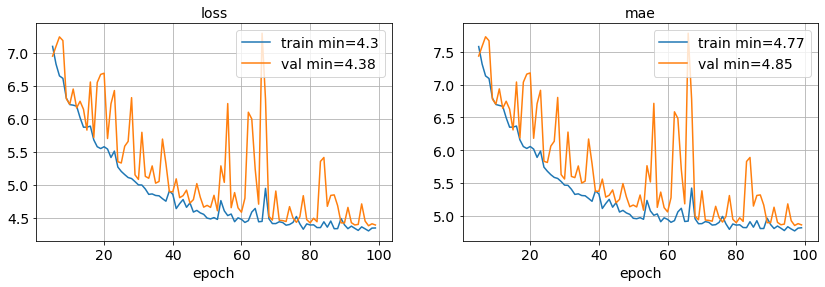

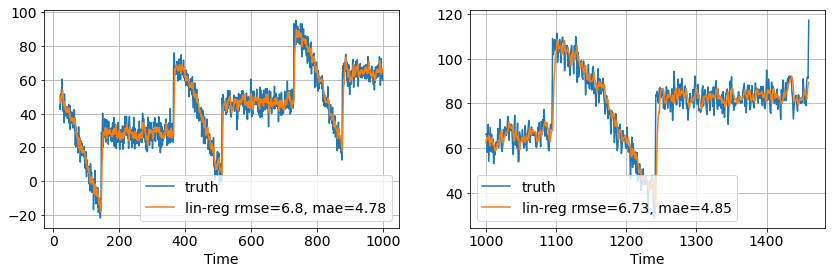

In [170]:
%%time
model = fit_nn(build_nn(), epochs=100, lr=3e-5)
plot_pred(model, 'lin-reg')

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 20)                420       
                                                                 
 dense_57 (Dense)            (None, 1)                 21        
                                                                 
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________
CPU times: total: 28.1 s
Wall time: 18.4 s


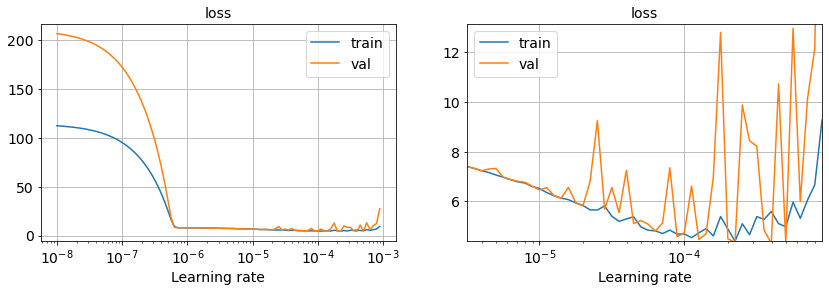

In [171]:
%%time
model = fit_nn(build_nn(dense_d=20), epochs=100, lr=-1)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 20)                420       
                                                                 
 dense_59 (Dense)            (None, 1)                 21        
                                                                 
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________
12/12 [==============================] - 0s 7ms/step
CPU times: total: 1min 13s
Wall time: 48.4 s


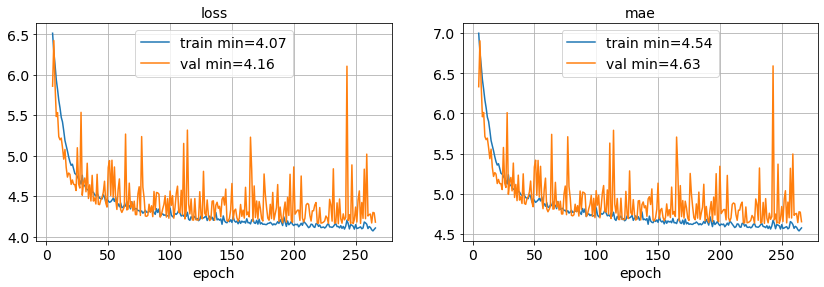

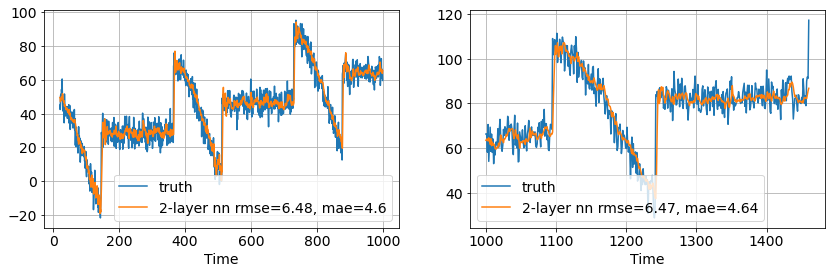

In [172]:
%%time
model = fit_nn(build_nn(dense_d=20), epochs=500, lr=2e-5)
plot_pred(model, '2-layer nn')

In [36]:
def build_rnn(rnn_d=[40]):
    layers = [keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                  input_shape=[window])]
    layers += [keras.layers.SimpleRNN(d, return_sequences=True) for d in rnn_d[:-1]]
    layers += [
        keras.layers.SimpleRNN(rnn_d[-1]),
        keras.layers.Dense(1),
        keras.layers.Lambda(lambda x: x * 100.)
    ]
    
    model = keras.models.Sequential(layers)
    model.summary()
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
31/31 [==============================] -

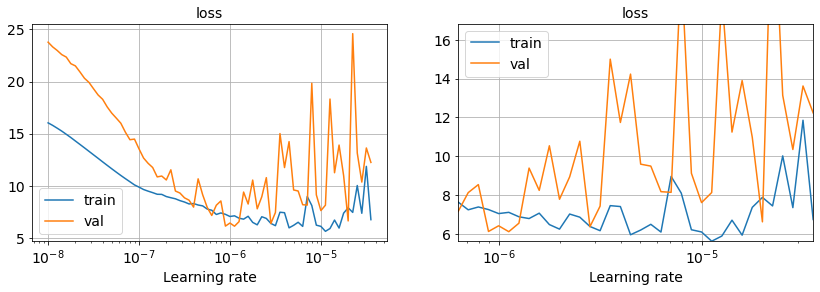

In [31]:
%%time
model = fit_nn(build_rnn(rnn_d=[40, 40]), epochs=120, lr=-1, vb=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
31/31 [==============================] -

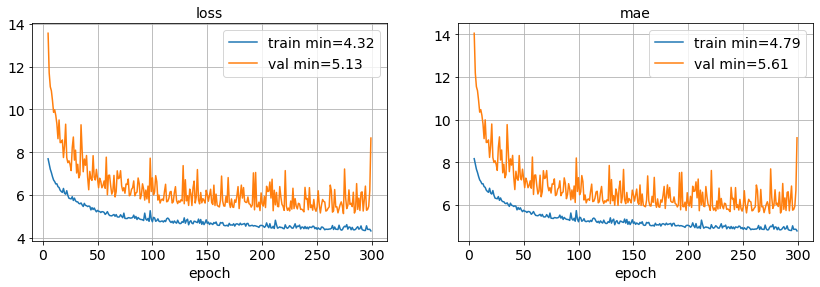

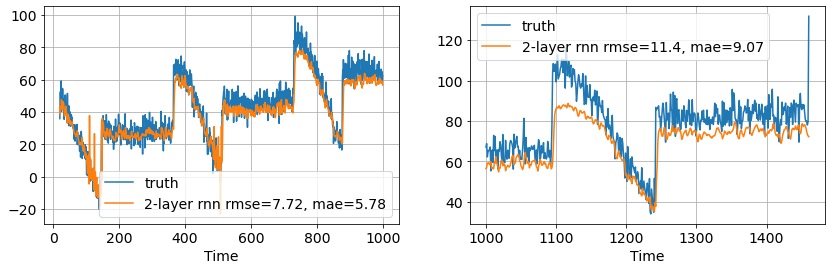

In [37]:
%%time
model = fit_nn(build_rnn(rnn_d=[40, 40]), epochs=300, lr=1e-6, vb=1)
plot_pred(model, '2-layer rnn')